In [1]:
#packages import
import os
os.chdir('..') #cd to PiperNET folder

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.rnaseq_utils import *

#config file path
config_path = Path('config/rnaseq_dataprep.yaml')

In [4]:
### Data import ###

#proteomes
proteome_list = get_config(config_path, data='proteome_csv')

for sample, path in proteome_list.items(): 
    proteome_list[sample] = pd.read_csv(path, index_col='id') #update proteome_list with dfs

#unique df with all proteomes
proteomes_all = pd.DataFrame()
for sample, proteome in proteome_list.items(): #iterate over each proteome in proteome_list
    proteome['sample'] = sample #add 'sample' column with sample name (e.g., piepr09)
    proteome.columns = [col.split('_', 1)[1] if 'rep' in col else col for col in proteome.columns] #remove sample name from tpm cols
    proteomes_all = pd.concat([proteomes_all, proteome]) #concat df


#sonicparanoid
sonicpd_path = get_config(config_path, data='various', file='sonicparanoid')
sonicpd = import_sonicpd(sonicpd_path)

#blastDB paths
blastDB_paths = get_config(config_path, data='blastDB')

#sequences paths
seq_paths = get_config(config_path, data='enzymeDB')

#prefixes
prefixes = get_config(config_path, data='prefix', filepaths=False)

# BLASTp P. nigrum sequences
Enzymes in the piperine biosynthetic pathway characterized in P. nigrum are BLASTed against all my transcriptomes. 
Enzyme sequences:
- PnBAHD1 (BAHD acyltransferase)
- PnBAHD2 (BAHD acyltransferase)
- PnCYP719A37 (CYP450)
- PnPIPCoAL (Piperic acid-CoA-ligase)
- PnFDS1 (Feruloyldiketide-CoA synthases)
- PnFDS2 (Feruloyldiketide-CoA synthases)
- PnLDC (Lysine decarboxylase)
- PnCAO (Copper amine oxidase) 

In [11]:
#keep only Pn sequences
seq_paths = {k: v for k, v in seq_paths.items() if 'Pn' in k}

#BLASTp all seqs vs all proteomes
hits_all = run_blastp(seq_paths, blastDB_paths, min_cov=50, min_sim=50)

#create sample column based on hit's prefix
hits_all['sample'] = hits_all['hit'].str.split('_').str[0] + '_'
hits_all['sample'] = hits_all['sample'].map({k: v for v, k in prefixes.items()})

Querying data/rna-seq/enzyme_seq/PnBAHD1.fasta in piper06 transcriptome...
14 hits found for PnBAHD1 in piper06 transcriptome.
Querying data/rna-seq/enzyme_seq/PnBAHD1.fasta in piper09 transcriptome...
24 hits found for PnBAHD1 in piper09 transcriptome.
Querying data/rna-seq/enzyme_seq/PnBAHD1.fasta in piper10 transcriptome...
23 hits found for PnBAHD1 in piper10 transcriptome.
Querying data/rna-seq/enzyme_seq/PnBAHD1.fasta in piper12 transcriptome...
18 hits found for PnBAHD1 in piper12 transcriptome.
Querying data/rna-seq/enzyme_seq/PnBAHD1.fasta in piper20 transcriptome...
10 hits found for PnBAHD1 in piper20 transcriptome.
Querying data/rna-seq/enzyme_seq/PnBAHD1.fasta in piper23 transcriptome...
29 hits found for PnBAHD1 in piper23 transcriptome.
Querying data/rna-seq/enzyme_seq/PnBAHD1.fasta in piper25 transcriptome...
29 hits found for PnBAHD1 in piper25 transcriptome.
Querying data/rna-seq/enzyme_seq/PnBAHD1.fasta in piper26 transcriptome...
21 hits found for PnBAHD1 in piper26

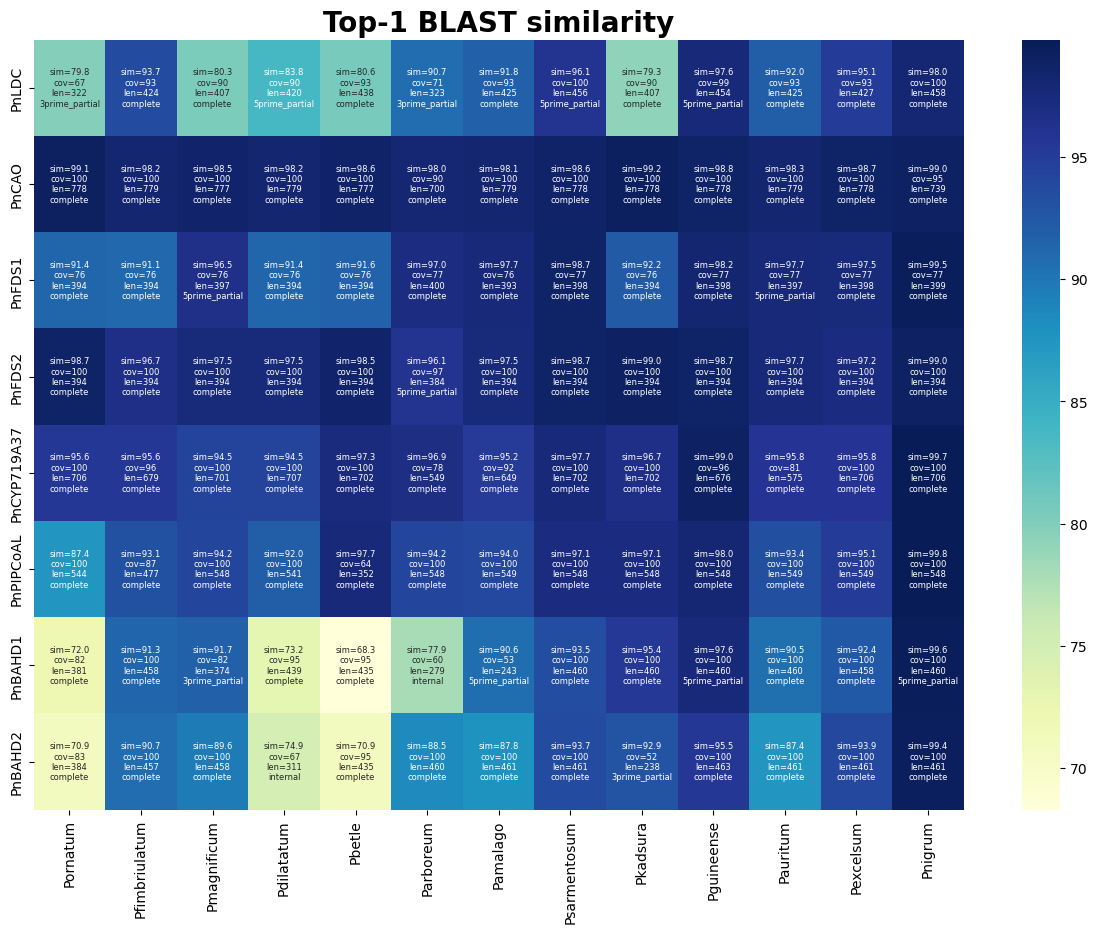

In [105]:
#create sequences-vs-sample matrix
matrix = pd.DataFrame(index=seq_paths.keys(), columns=proteome_list.keys())
matrix = matrix.reindex(['PnLDC', 'PnCAO', 'PnFDS1', 'PnFDS2', 'PnCYP719A37', 'PnPIPCoAL', 'PnBAHD1', 'PnBAHD2'])
annotations = pd.DataFrame(index=seq_paths.keys(), columns=proteome_list.keys())
annotations = annotations.reindex(['PnLDC', 'PnCAO', 'PnFDS1', 'PnFDS2', 'PnCYP719A37', 'PnPIPCoAL', 'PnBAHD1', 'PnBAHD2'])
full_annotation = True #if True, heatmap displays similarity, coverage, length, ORF type
annot_font = 6 #heatmpap text size

#fill each entry with similarity of top BLAST hit
for index, row in matrix.iterrows():
    for column in matrix.columns:
        hits_filt = hits_all.loc[(hits_all['query'] == index) & (hits_all['sample'] == column)].sort_values(by='similarity', ascending=False)
        if not hits_filt.empty:
            top_hit = hits_filt.iloc[0] #keep top hit (based on similarity)
            top_sim = top_hit['similarity'].round(1)
            top_len = len(top_hit['sequence'].replace('-', ''))
            top_cov = top_hit['coverage'].round(1)
            top_orf = proteomes_all.loc[top_hit['hit']]['orf_type']
            matrix.at[index, column] = top_sim
            if full_annotation==True:
                annotations.at[index, column] = ('sim='+str(top_sim)) + '\n' + ('cov='+str(top_cov)) + '\n' + ('len='+str(top_len)) + '\n' + (str(top_orf))
            else:
                annotations.at[index, column] = top_cov

#plot heatmap
species_names = get_config(config_path, data='species', filepaths=False)
matrix.rename(columns=species_names, inplace=True)

plt.figure(figsize=(15, 10))  # adjust the size of the plot as needed
sns.heatmap(matrix.astype(float), annot=annotations, fmt="", cmap='YlGnBu', annot_kws={"fontsize": annot_font})

# #clustermap
# sns.clustermap(matrix.astype(float), annot=annotations, fmt="", cmap='YlGnBu', annot_kws={"fontsize": annot_font})

plt.title('Top-1 BLAST similarity', fontsize=20, fontweight='bold')
plt.show()

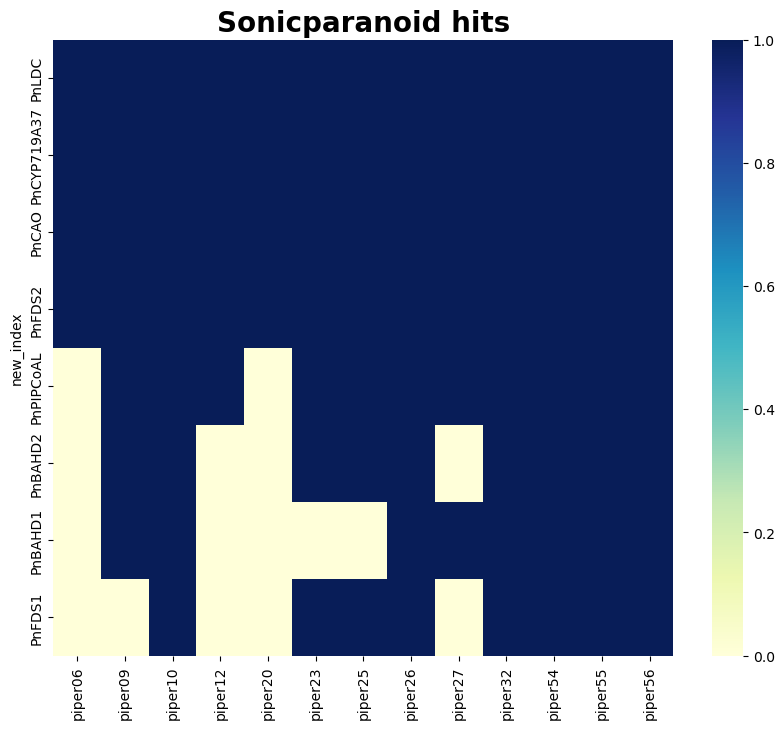

In [99]:
#piper56 best best hit per query
hits_p56 = hits_all[hits_all['sample'] == 'piper56'].sort_values(by='similarity', ascending=False).groupby('query').first()
hits_p56 = hits_p56['hit']

#Filter rows in sonicpd where any element in 'piper56' column is in hits_p56['hit'].values
filtered_sonicpd = sonicpd[sonicpd['piper56'].apply(lambda x: any(i in hits_p56.values for i in x))].copy()

# Create a mapping from the values in hits_p56 to their index
index_mapping = hits_p56.reset_index().set_index('hit')['query']

# Use the mapping to set the index in filtered_sonicpd
filtered_sonicpd['new_index'] = filtered_sonicpd['piper56'].apply(lambda x: [index_mapping[i] for i in x if i in index_mapping])
filtered_sonicpd = filtered_sonicpd.explode('new_index').reset_index(drop=True).set_index('new_index')

filtered_sonicpd = filtered_sonicpd[[col for col in filtered_sonicpd.columns if 'piper' in col]]
filtered_sonicpd

#replace entries with list lenght
filtered_sonicpd = filtered_sonicpd.applymap(lambda x: len(x))


#replace entries with presence/absence
filtered_sonicpd = filtered_sonicpd.applymap(lambda x: 1 if x > 0 else 0)
filtered_sonicpd

#display filtered_sonicpd as heatmap
plt.figure(figsize=(10, 8))  # adjust the size of the plot as needed
sns.heatmap(filtered_sonicpd.astype(float), cmap='YlGnBu')
plt.title('Sonicparanoid hits', fontsize=20, fontweight='bold')
plt.show()

In [88]:
#keep best hit (based on similarity) for each query
hits_p56 = hits_all[hits_all['sample'] == 'piper56'].sort_values(by='similarity', ascending=False).groupby('query').first()
hits_p56 = hits_p56['hit']

#Filter rows in sonicpd where any element in 'piper56' column is in hits_p56['hit'].values
filtered_sonicpd = sonicpd[sonicpd['piper56'].apply(lambda x: any(i in hits_p56.values for i in x))].copy()

# Create a mapping from the values in hits_p56 to their index
index_mapping = hits_p56.reset_index().set_index('hit')['query']

# Use the mapping to set the index in filtered_sonicpd
filtered_sonicpd['new_index'] = filtered_sonicpd['piper56'].apply(lambda x: [index_mapping[i] for i in x if i in index_mapping])
filtered_sonicpd = filtered_sonicpd.explode('new_index').reset_index(drop=True).set_index('new_index')

,group_size,sp_in_grp,seed_ortholog_cnt,piper06,piper09,piper10,piper12,piper20,piper23,piper25,piper26,piper27,piper32,piper54,piper55,piper56
query,,,,,,,,,,,,,,,,
PnBAHD1,28,13,28,[Porn_g33169_i0.p1],"[Pfim_g13841_i0.p1, Pfim_g20001_i0.p2]","[Pmag_g26444_i0.p1, Pmag_g51456_i0.p2]",[Pdil_g28582_i0.p1],[Pbet_g13204_i0.p1],"[Parb_g920_i5.p2, Parb_g920_i0.p2, Parb_g20334...","[Pama_g25273_i0.p1, Pama_g28487_i0.p1]","[Psar_g24071_i0.p2, Psar_g26852_i0.p1, Psar_g2...",[Pkad_g25241_i0.p1],"[Pgui_g18706_i0.p1, Pgui_g24932_i0.p1]","[Paur_g13996_i0.p1, Paur_g15297_i0.p1]","[Pexc_g14971_i0.p1, Pexc_g15896_i0.p1, Pexc_g1...","[Pnig_g21843_i0.p1, Pnig_g22529_i0.p1, Pnig_g2..."
PnBAHD2,20,13,20,[Porn_g5281_i5.p1],"[Pfim_g10278_i0.p1, Pfim_g10278_i1.p1]",[Pmag_g10485_i1.p1],"[Pdil_g1643_i1.p1, Pdil_g1643_i3.p1]",[Pbet_g6377_i2.p1],"[Parb_g4826_i0.p2, Parb_g4826_i2.p1, Parb_g482...",[Pama_g6334_i1.p1],"[Psar_g9999_i11.p1, Psar_g9999_i5.p1]",[Pkad_g5858_i4.p1],[Pgui_g3768_i2.p1],[Paur_g1883_i1.p1],[Pexc_g7697_i7.p1],"[Pnig_g14064_i0.p1, Pnig_g14064_i2.p1]"
PnCAO,15,13,15,[Porn_g6146_i2.p1],[Pfim_g3985_i1.p1],[Pmag_g3131_i3.p1],[Pdil_g4191_i1.p1],[Pbet_g4057_i5.p1],"[Parb_g8070_i0.p1, Parb_g8070_i1.p1]",[Pama_g3232_i1.p1],[Psar_g7724_i5.p1],[Pkad_g6634_i2.p1],[Pgui_g8920_i0.p1],[Paur_g7848_i0.p1],[Pexc_g3713_i1.p1],"[Pnig_g6346_i6.p1, Pnig_g7130_i2.p1]"
PnCYP719A37,14,13,14,[Porn_g15459_i1.p1],[Pfim_g13608_i1.p1],[Pmag_g27854_i0.p1],[Pdil_g16718_i2.p1],[Pbet_g18249_i2.p1],[Parb_g14045_i2.p1],[Pama_g24981_i1.p1],[Psar_g25232_i0.p1],[Pkad_g23510_i0.p1],[Pgui_g15351_i1.p1],[Paur_g16197_i1.p1],[Pexc_g12730_i1.p1],"[Pnig_g909_i25.p1, Pnig_g8672_i1.p1]"
PnFDS1,12,11,12,[],[Pfim_g13419_i0.p1],[Pmag_g20945_i0.p1],[Pdil_g13129_i1.p1],[],"[Parb_g5154_i4.p1, Parb_g5634_i9.p1]",[Pama_g1931_i1.p1],[Psar_g7932_i3.p1],[Pkad_g14138_i0.p1],[Pgui_g12921_i1.p1],[Paur_g14455_i0.p1],[Pexc_g6357_i1.p1],[Pnig_g3003_i2.p1]
PnFDS2,12,9,12,[],[Pfim_g18073_i0.p1],[Pmag_g29130_i0.p1],[],[],"[Parb_g13637_i0.p1, Parb_g21671_i0.p1]","[Pama_g22729_i0.p1, Pama_g26153_i0.p1]",[Psar_g30166_i0.p1],[],[Pgui_g24765_i0.p1],"[Paur_g15975_i0.p1, Paur_g16090_i0.p1]",[Pexc_g15841_i0.p1],[Pnig_g23687_i0.p1]
PnLDC,8,8,8,[],[Pfim_g15326_i0.p1],[Pmag_g42254_i0.p1],[],[],[],[],[Psar_g25416_i0.p1],[Pkad_g26185_i0.p1],[Pgui_g23318_i0.p1],[Paur_g19590_i0.p1],[Pexc_g16044_i0.p1],[Pnig_g21757_i0.p1]
PnPIPCoAL,8,8,8,[],[],[Pmag_g1428_i4.p1],[],[],[Parb_g24578_i0.p1],[Pama_g20295_i1.p1],[Psar_g28415_i1.p1],[],[Pgui_g21625_i0.p1],[Paur_g19181_i0.p1],[Pexc_g14782_i0.p1],[Pnig_g8933_i0.p1]


In [106]:
proteomes_all

,sequence,length,orf_type,orientation,orf_score,transcript_length,transcript_coverage,pfam,domain,pfam_e-value,...,sample,medfr_rep1,medfr_rep2,medfr_rep3,oldfr_rep1,oldfr_rep2,oldfr_rep3,youfr_rep1,youfr_rep2,youfr_rep3
id,,,,,,,,,,,,,,,,,,,,,
Porn_g43609_i0.p1,MFIQLSILSRLFKWSGCKSFLVIHLDHVFALICSYICGKWRFMEEA...,108,complete,(+),14.40,739,10918.261261,NaN,NaN,NaN,...,piper06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Porn_g43610_i0.p1,EKGSTFATLLPSSFFFLLPHLLLHIAAMDSRSRSYGEGRSQVVVYG...,141,5prime_partial,(+),28.08,739,996.231231,PF12023.12,Domain of unknown function (DUF3511),4.000000e-26,...,piper06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Porn_g3472_i6.p1,FDFSGIGLLFSFGLKGERRVSSSSAMAKLKLYVDRMSQPSRALIIF...,154,5prime_partial,(+),31.97,739,470.704204,PF02798.24,"Glutathione S-transferase, N-terminal domain",9.400000e-16,...,piper06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Porn_g40098_i1.p1,MAGAETRLKEVASDDPGRGEVASGVQVDCFTEDLHDVTLHFQIIRV...,112,complete,(+),9.37,739,298.921922,PF16093.9,Proteasome assembly chaperone 4,5.000000e-13,...,piper06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Porn_g25991_i1.p1,MAVNLRRLLPLIRRSPPPATTPAISSHPSAAYSWGFRLFGSDDRKL...,118,complete,(+),21.51,739,122.043544,PF07896.16,Protein of unknown function (DUF1674),7.100000e-18,...,piper06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pnig_g20877_i1.p1,MDVNIWMEFLQGMLKALAATAVVLVAVLLSFFQHLGLEKEMVYAIF...,255,complete,(+),47.18,1338,2739.152569,PF03649.17,Uncharacterised protein family (UPF0014),3.800000e-68,...,piper56,217.431,269.065,189.369,12.233,11.415,7.323,82.956,86.735,95.012
Pnig_g19557_i2.p1,MAAPASAAAISAPFGSQFKSGDVKLRKMGASGNPGRTALRSSLNQG...,141,complete,(+),21.45,1338,1659.356522,NaN,NaN,NaN,...,piper56,29.010,21.766,24.176,26.773,27.284,27.143,19.105,20.137,22.121
Pnig_g28332_i0.p1,MEIKVEDESKKSQHQPLLRHNNGTSELSDDRSSPITDKEGEAVQTF...,225,complete,(+),20.81,1338,601.434783,PF05078.16,Protein of unknown function (DUF679),4.900000e-67,...,piper56,42.861,40.587,34.569,125.103,135.575,78.378,4.048,3.834,5.246
